In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


<AxesSubplot:xlabel='median_house_value', ylabel='Count'>

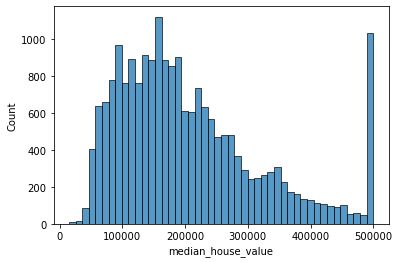

In [4]:
sns.histplot(df.median_house_value)

## Question 1
Find a feature with missing values. How many missing values does it have?

In [8]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

## Question 2
What's the median (50% percentile) for variable 'population'?

In [9]:
df.population.median()

1166.0

## Split the data
Shuffle the initial dataset, use seed 42.\
Split your data in train/val/test sets, with 60%/20%/20% distribution.\
Make sure that the target value ('median_house_value') is not in your dataframe.\
Apply the log transformation to the median_house_value variable using the np.log1p() function.

In [62]:
df.ocean_proximity.unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [63]:
cleaned_df = df.drop('ocean_proximity', axis=1)

In [64]:
np.random.seed(42)

n = len(df)
idx = np.arange(n)

np.random.shuffle(idx)

In [65]:
idx

array([20046,  3024, 15663, ...,  5390,   860, 15795])

In [66]:
n_val = int(n*0.2)
n_test = int(n*0.2)
n_train = n - n_val - n_test

print(n_train, n_val, n_test)

12384 4128 4128


In [67]:
df_train = cleaned_df.iloc[idx[:n_train]].copy()
df_val = cleaned_df.iloc[idx[n_train:n_train+n_val]].copy()
df_test = cleaned_df.iloc[idx[n_train+n_val:]].copy()

In [68]:
len(df_train)

12384

In [69]:
y_train = df_train.median_house_value.copy()
y_val = df_val.median_house_value.copy()
y_test = df_test.median_house_value.copy()

In [70]:
df_train.drop('median_house_value', axis=1, inplace=True)
df_val.drop('median_house_value', axis=1, inplace=True)
df_test.drop('median_house_value', axis=1, inplace=True)

In [71]:
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)
y_val = np.log1p(y_val)

## Question 3
We need to deal with missing values for the column from Q1.\
We have two options: fill it with 0 or with the mean of this variable.\
Try both options. For each, train a linear regression model without regularization using the code from the lessons.\
For computing the mean, use the training only!\
Use the validation dataset to evaluate the models and compare the RMSE of each option.\
Round the RMSE scores to 2 decimal digits using round(score, 2)\
Which option gives better RMSE?

In [86]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [87]:
def prepare_X(df, mean_=True):
    df_num = df.copy()
    if mean_:
        df_num = df_num.apply(lambda x: x.fillna(x.mean()),axis=0)
    else:
        df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [89]:
X_train = prepare_X(df_train, mean_=False)
w_0, w = train_linear_regression(X_train, y_train)
y_pred = w_0 + X_train.dot(w)

In [90]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [94]:
rmse(y_train, y_pred).round(2)

0.34

In [92]:
X_train = prepare_X(df_train, mean_=True)
w_0, w = train_linear_regression(X_train, y_train)
y_pred = w_0 + X_train.dot(w)

In [95]:
rmse(y_train, y_pred).round(2)

0.34

## Question 4
Now let's train a regularized linear regression. \
For this question, fill the NAs with 0.\
Try different values of r from this list: [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10].\
Use RMSE to evaluate the model on the validation dataset.\
Round the RMSE scores to 2 decimal digits.\
Which r gives the best RMSE?

In [98]:
X_train = prepare_X(df_train, mean_=False)

In [99]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [104]:
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_train.dot(w)
    score = rmse(y_train, y_pred).round(2)
    print(r, score, w_0)

0 0.34 -11.686975242036949
1e-06 0.34 -11.686959175729026
0.0001 0.34 -11.685368865034674
0.001 0.34 -11.670931317799855
0.01 0.34 -11.528493585632152
0.1 0.34 -10.274500282195046
1 0.35 -4.920480897742162
5 0.35 -1.4820957456212156
10 0.35 -0.7899311831779148


## Question 5
We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.\
Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].\
For each seed, do the train/validation/test split with 60%/20%/20% distribution.\
Fill the missing values with 0 and train a model without regularization.\
For each seed, evaluate the model on the validation dataset and collect the RMSE scores.\
What's the standard deviation of all the scores? To compute the standard deviation, use np.std.\
Round the result to 3 decimal digits (round(std, 3))\
Note: Standard deviation shows how different the values are. If it's low, then all values are approximately the same. If it's high, the values are different. If standard deviation of scores is low, then our model is stable.

In [161]:
rmses = []

for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    
    np.random.seed(seed)
    np.random.shuffle(idx)

    df_train = cleaned_df.iloc[idx[:n_train]].copy()
    df_val = cleaned_df.iloc[idx[n_train:n_train+n_val]].copy()
    df_test = cleaned_df.iloc[idx[n_train+n_val:]].copy()

    y_train = df_train.median_house_value.copy()
    y_val = df_val.median_house_value.copy()
    y_test = df_test.median_house_value.copy()

    df_train.drop('median_house_value', axis=1, inplace=True)
    df_val.drop('median_house_value', axis=1, inplace=True)
    df_test.drop('median_house_value', axis=1, inplace=True)

    y_train = np.log1p(y_train)
    y_test = np.log1p(y_test)
    y_val = np.log1p(y_val)
    
    
    X_train = prepare_X(df_train, mean_=False)
    w_0, w = train_linear_regression(X_train, y_train)
    X_val = prepare_X(df_val, mean_=False)
    y_pred = w_0 + X_val.dot(w)
    
    rmses.append(rmse(y_val, y_pred))

In [162]:
rmses

[0.33831784284146366,
 0.34548155272450864,
 0.3377242288528605,
 0.3460515809807479,
 0.34967188703887087,
 0.3500112710772948,
 0.34346731104095496,
 0.3376737453610698,
 0.3416421517045011,
 0.3522514926587404]

In [163]:
np.std(rmses).round(3)

0.005

## Question 6
Split the dataset like previously, use seed 9.\
Combine train and validation datasets.\
Fill the missing values with 0 and train a model with r=0.001.\
What's the RMSE on the test dataset?

In [130]:
seed = 9
np.random.seed(seed)
np.random.shuffle(idx)

df_train = cleaned_df.iloc[idx[:n_train]].copy()
df_val = cleaned_df.iloc[idx[n_train:n_train+n_val]].copy()
df_test = cleaned_df.iloc[idx[n_train+n_val:]].copy()

y_train = df_train.median_house_value.copy()
y_val = df_val.median_house_value.copy()
y_test = df_test.median_house_value.copy()

df_train.drop('median_house_value', axis=1, inplace=True)
df_val.drop('median_house_value', axis=1, inplace=True)
df_test.drop('median_house_value', axis=1, inplace=True)

y_train = np.log1p(y_train)
y_test = np.log1p(y_test)
y_val = np.log1p(y_val)


X_train = prepare_X(df_train, mean_=False)
w_0, w = train_linear_regression_reg(X_train, y_train, r=0.001)
X_val = prepare_X(df_val, mean_=False)
y_pred = w_0 + X_val.dot(w)
rmse(y_val, y_pred)

0.35122887040818673